# This notebook is for training CGR4J model for hydrological similar basin

- Streamflow --- NWIS
- Weather --- Daymet

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib notebook
import seaborn as sns
import os
import copy

In [2]:
os.chdir('..')
os.chdir('..')

In [3]:
from tools.train_lumped_models import build_train_CemaneigeGR4J
from tools.weather import preprocess_weather
from tools.metrics import calc_nse, calc_kge

# Import Data

In [4]:
gauges = pd.read_csv('data/HydroSimilarStations/valid_gauge_info.txt', sep = ',', dtype='str')
gauges

Gauges          lat           lon             datum_m  \
0  01175670  42.26481407   -72.0042418           191.84112   
1  01181000  42.23731169    -72.895654          116.720112   
2  01111500  41.99648716  -71.56200758  54.626256000000005   
3  01097300  42.51259289  -71.40422829           46.997112   
4  01198000   42.1929083   -73.3912306  210.11388000000002   
5  01174565  42.45508906   -72.3817516  164.42131200000003   
6  01082000   42.8625837  -71.95924609  222.88500000000002   
7  01095220  42.41092507   -71.7911829          121.700544   
8  01176000  42.18231566    -72.263691          118.676928   

  Drainage Area, sqmile  
0                  8.81  
1                    94  
2                  91.2  
3                  12.8  
4                    51  
5                  12.6  
6                  68.1  
7                  29.1  
8                   150

In [11]:
model_params_metrics = pd.DataFrame([], columns = ['Datum', 'Lat', 'Lon', 'Drainage_area,sqmile', 
                                                   'CTG', 'Kf', 'x1', 'x2', 'x3', 'x4', 
                                                   'NSE_cal', 'NSE_val', 'NSE_total','KGE_cal','KGE_val', 'KGE_total'], 
                                                    index = gauges.loc[:,'Gauges'])

# Flow unit here is cfsm or cmsk
for i in range(len(gauges)):
    gauge_height = float(gauges.loc[:, 'datum_m'].iloc[i]) # ft to m
    model_params_metrics['Datum'].iloc[i] = gauge_height
    
    gauge_lon = float(gauges.loc[:, 'lon'].iloc[i])
    model_params_metrics['Lon'].iloc[i] = gauge_lon
    gauge_lat = float(gauges.loc[:, 'lat'].iloc[i])
    model_params_metrics['Lat'].iloc[i] = gauge_lat
    
    gauge_contributing_area = float(gauges.loc[:, 'Drainage Area, sqmile'].iloc[i])
    model_params_metrics['Drainage_area,sqmile'].iloc[i] = gauge_contributing_area
    
    gauge_id = gauges.loc[:, 'Gauges'].iloc[i]
    
    # Load Gauge data, drop rows where no observations
    df = pd.read_csv('data/HydroSimilarStations/daymet_streamflow/{gauge_id}.csv'.format(gauge_id = gauge_id), index_col=0, parse_dates=True).dropna()
    weather_type = 'daymet'
    weather_df = df.iloc[:, :-1]
    
    cal_val_date = df.index[100:] # first 100 days as warm up
    cal_date = cal_val_date[:int(len(cal_val_date) * 0.8)]
    val_date = cal_val_date[int(len(cal_val_date) * 0.8):]
    
    # cfsm
    obs_flow = df.iloc[:, -1] * 35.3146667/gauge_contributing_area# to cfsm

    # cmsk, cubic meter per second per sqaure kilometers
    #obs_flow = df.iloc[:,-1]/gauge_contributing_area/2.58999 # m3/s/km2, cmsk
    
    cal_flow = obs_flow.loc[cal_date]
    val_flow = obs_flow.loc[val_date]
    
    # Build and Train
    try:
        model = build_train_CemaneigeGR4J(weather_type, cal_flow, weather_df, gauge_height, lat = gauge_lat) # Daymet
    except:
        print(gauge_id + ' model failed to be calibrated, move to next gauge')
        continue
    
    # Use the model to simulate
    processed_weather_df = preprocess_weather(weather_df, weather_type,  gauge_lat)
    total_flow = model.simulate(processed_weather_df['prec'], processed_weather_df['tmean'], 
                                     processed_weather_df['tmin'], processed_weather_df['tmax'], 
                                     processed_weather_df['pet'], gauge_height)
    total_flow = pd.DataFrame(total_flow, index=processed_weather_df.index, columns=['Sim Flow'])
    cal_flow_sim = total_flow.loc[cal_date]
    val_flow_sim = total_flow.loc[val_date]
    
    try:
    
        # Evaluate the model and save the NSE and KGEs
        # NSE
        model_params_metrics['NSE_cal'].iloc[i] =  calc_nse(cal_flow_sim.values.ravel(), cal_flow.values.ravel())
        model_params_metrics['NSE_val'].iloc[i] = calc_nse(val_flow_sim.values.ravel(), val_flow.values.ravel())
        model_params_metrics['NSE_total'].iloc[i]= calc_nse(total_flow.loc[cal_val_date].values.ravel(), obs_flow.loc[cal_val_date].values.ravel())
        # KGE
        model_params_metrics['KGE_cal'].iloc[i] = calc_kge(cal_flow_sim.values.ravel(), cal_flow.values.ravel())
        model_params_metrics['KGE_val'].iloc[i] = calc_kge(val_flow_sim.values.ravel(), val_flow.values.ravel())
        model_params_metrics['KGE_total'].iloc[i]= calc_kge(total_flow.loc[cal_val_date].values.ravel(), obs_flow.loc[cal_val_date].values.ravel())
    except:
        print('Inf or NaN or KGE or NSE')
    
    # Save the parameters
    for p in model.get_parameter_names():
        value = model.get_params()[p] # get
        model_params_metrics[p].iloc[i] = value # save

     fun: 1.4937449018827706
     jac: array([ 0.00000000e+00, -3.24185125e-06,  1.17239458e-05,  2.95319325e-06,
       -2.35367429e-06,  5.46229731e-06])
 message: 'Optimization terminated successfully.'
    nfev: 2633
     nit: 26
 success: True
       x: array([ 6.16423074e-02,  5.25835043e+00,  2.39824213e+02, -4.85603337e-01,
        1.16006261e+02,  1.64246971e+00])
     fun: 6.118503459177556
     jac: array([ 0.00000000e+00, -4.26325644e-06,  0.00000000e+00,  5.95079538e-06,
       -7.99360512e-07,  4.26325644e-06])
 message: 'Optimization terminated successfully.'
    nfev: 1949
     nit: 17
 success: True
       x: array([ 0.17064456,  2.72906865, 94.15121008,  0.57226089, 50.71587641,
        1.43758626])
     fun: 0.873499400323163
     jac: array([ 0.00000000e+00, -7.77156122e-07,  2.22044429e-08, -7.07212067e-06,
        2.99760405e-07, -1.07025500e-05])
 message: 'Optimization terminated successfully.'
    nfev: 2469
     nit: 22
 success: True
       x: array([5.655436

In [13]:
model_params_metrics

Datum        Lat        Lon Drainage_area,sqmile       CTG  \
Gauges                                                                      
01175670   191.84112  42.264814 -72.004242                 8.81  0.061642   
01181000  116.720112  42.237312 -72.895654                 94.0  0.170645   
01111500   54.626256  41.996487 -71.562008                 91.2  0.056554   
01097300   46.997112  42.512593 -71.404228                 12.8  0.102157   
01198000   210.11388  42.192908 -73.391231                 51.0  0.031988   
01174565  164.421312  42.455089 -72.381752                 12.6  0.047885   
01082000     222.885  42.862584 -71.959246                 68.1  0.018245   
01095220  121.700544  42.410925 -71.791183                 29.1  0.034532   
01176000  118.676928  42.182316 -72.263691                150.0   0.07876   

                Kf          x1        x2          x3        x4   NSE_cal  \
Gauges                                                                     
01175670   5.25835  239.824213 -0.485603  116.006261   1.64247  0.735255   
01181000  2.729069    94.15121  0.572261   50.715876  1.437586  0.486183   
01111500  5.644943  428.198252  0.040318  100.683382  2.016601  0.860473   
01097300  5.527557   422.34133 -1.219657  105.883857  2.089392     0.823   
01198000  8.551404   114.35438 -0.724973  109.058609  1.324393  0.662829   
01174565  4.331532  235.246262 -0.099055   50.079084  1.537207  0.686872   
01082000  5.499495  308.060126  0.290106   85.131785  1.795976  0.791677   
01095220  3.616543  284.370667  1.188157   63.547844  1.823649  0.748565   
01176000  7.637186  126.835921 -1.013071  474.826997  2.454783  0.764669   

           NSE_val NSE_total   KGE_cal   KGE_val KGE_total  
Gauges                                                      
01175670  0.364704  0.683304   0.83118  0.627923  0.799954  
01181000  0.638502  0.511795  0.690882  0.793978  0.725558  
01111500  0.796452  0.851006   0.89756  0.861938  0.893322  
01097300  0.733398  0.814945  0.864736  0.697302  0.854759  
01198000   0.56733    0.6518  0.799327  0.722042  0.790977  
01174565  0.504762  0.655792  0.822542  0.747055  0.809615  
01082000  0.621093  0.768568  0.884505  0.677725  0.857349  
01095220  0.672581  0.734845   0.77425  0.789411  0.783005  
01176000  0.736625  0.760833  0.830196  0.787114  0.823995

In [14]:
model_params_metrics.to_csv('data/HydroSimilarStations/parameters/Param_Metrics_RRMPG_CGR4J.txt')

# View the results

In [9]:
# Load Gauge data
df = pd.read_csv('data/HydroSimilarStations/daymet_streamflow/01174565.csv', index_col=0, parse_dates=True).dropna()
weather_type = 'daymet'
weather_df = df.iloc[:, :-1]

cal_val_date = df.index[100:] # first 100 days as warm up
cal_date = cal_val_date[:int(len(cal_val_date) * 0.8)]
val_date = cal_val_date[int(len(cal_val_date) * 0.8):]

obs_flow = df.iloc[:, -1] * 35.3146667/12.6#cfsm
cal_flow = obs_flow.loc[cal_date]
val_flow = obs_flow.loc[val_date]

model = build_train_CemaneigeGR4J(weather_type, cal_flow, weather_df, gauge_height, lat = gauge_lat)
# Use the model to simulate
processed_weather_df = preprocess_weather(weather_df, weather_type,  gauge_lat)
total_flow = model.simulate(processed_weather_df['prec'], processed_weather_df['tmean'], 
                                 processed_weather_df['tmin'], processed_weather_df['tmax'], 
                                 processed_weather_df['pet'], gauge_height)
total_flow = pd.DataFrame(total_flow, index=processed_weather_df.index, columns=['Sim Flow'])
cal_flow_sim = total_flow.loc[cal_date]
val_flow_sim = total_flow.loc[val_date]

     fun: 2.131600130485124
     jac: array([ 0.00000000e+00, -1.24344980e-06,  0.00000000e+00,  3.50830476e-06,
        4.44089173e-08, -2.48689959e-06])
 message: 'Optimization terminated successfully.'
    nfev: 2537
     nit: 24
 success: True
       x: array([ 9.22089128e-03,  4.33265473e+00,  2.36288526e+02, -9.02326562e-02,
        4.98068049e+01,  1.53822159e+00])


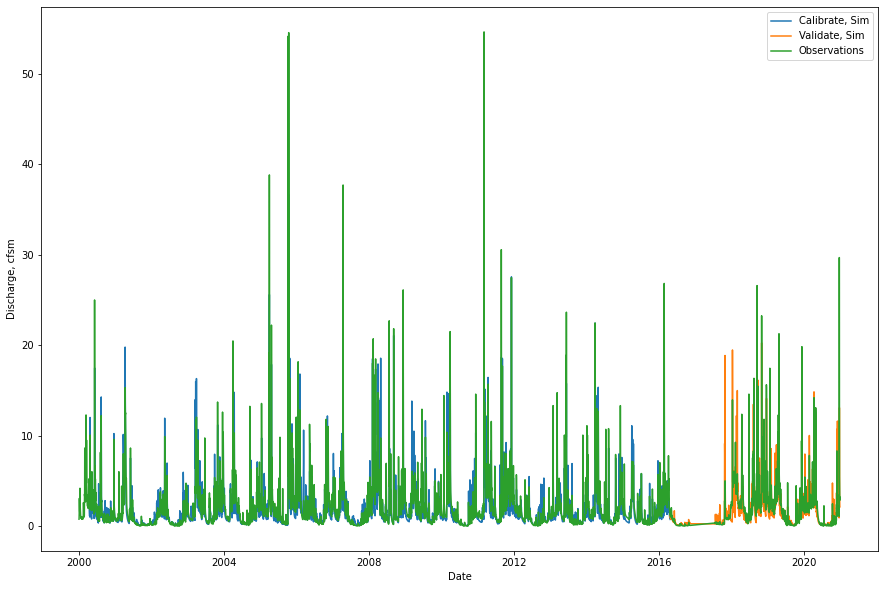

In [10]:
plt.figure(figsize=(15,10))
plt.plot(cal_flow_sim, label = 'Calibrate, Sim')
plt.plot(val_flow_sim, label = 'Validate, Sim')
plt.plot(obs_flow, label = 'Observations')
plt.ylabel('Discharge, cfsm')
plt.xlabel('Date')
plt.legend()
plt.show()

In [11]:
calc_kge(val_flow_sim.values.ravel(), val_flow.values.ravel())

0.7471566864196506